## This is a FSI problem of 1 passive plate linked with spring and damper, oscillating in fluid

In [94]:
using Roots
func(x) = 1/10*(sin(x)+sin(2x)+sin(3x)+sin(4x)+sin(5x)+sin(6x)+sin(7x)+sin(8x)+sin(9x)) - sin(0.1*π)
α₀ = 9*find_zero(func,0.1)

0.6421867650292312

In [95]:
using Revise

using BSON: @save, @load

using Pkg
Pkg.activate("..")
using FSInteraction

In [96]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

In [97]:
filename = "2dFlag_1body";

## <span style="color:blue"> Set up rigid body with Dyn3d

#### Include any joint-body setup script from Dyn3d

In [98]:
# problem dimension
ndim = 2
# numerical params
tf = 2
dt = 1e-3
scheme = "Liska"
st = 3
tol = 1e-4
num_params = NumParams(tf, dt, scheme, st, tol)
# gravity
gravity = [0., -1.0, 0.]

# set up system config info
config_system = ConfigSystem(ndim, gravity, num_params)

# set up bodys
nbody = 1
# config_body = ConfigBody(nbody)
config_body = ConfigBody(nbody, 4,
    [0. 0.; 1. 0.; 1. 1.0/nbody; 0. 1.0/nbody], 1.5)
config_bodys = fill(config_body, nbody)

# set up joints
njoint = nbody
stiff = 0.02
damp = 0.005
config_joints = Vector{ConfigJoint}(undef,njoint)

dof = Dof(3, "passive", stiff, damp, Motions())

config_joints[1] = ConfigJoint(njoint, "revolute",
    [0.,0.,-π/2,1.5,3.0,0.], zeros(Float64,6), 0, [dof], [α₀])

 joint type = revolute
 joint position in parent body coord = [0.0, 0.0, -1.5708, 1.5, 3.0, 0.0]
 joint position in child body coord = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 joint unconstrained dof = 3, under passive motion
 initial unconstrained dof position = [0.642187]
 initial unconstrained dof velocity = [0.0]


#### Build joint-body chain

In [99]:
bs, js, bsys = BuildChain(config_bodys, config_joints, config_system)
bd = BodyDyn(bs, js, bsys)

This is a 1 body-joint system, system is fixed in space

#### Initialize rigid body system state to complete body-joint information

In [100]:
bd, soln₀ = InitSystem!(bd);

#### Initialize u and λ container

In [101]:
qJ = soln₀.qJ
v = soln₀.v
λ_dim = bd.sys.ncdof_HERK
λ = zeros(Float64,λ_dim);

#### Get body verts for plotting

In [102]:
@get bd (bs, js, sys)
bs, js, sys = UpdatePosition!(bs, js, sys, soln₀.qJ)
vs₀ = VertsHistory(sys.nbody, bs);

#### Plot body only

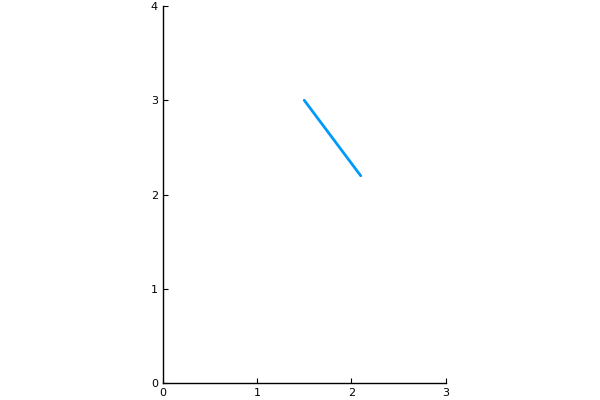

In [103]:
p = plot()
for i = 1:sys.nbody
    plot!(p,vs₀[i,2:3,1], vs₀[i,2:3,2],linewidth=2)
end
plot!(xlims=(0,3), ylims=(0,4), ratio=1, legend=false)

## <span style="color:blue"> Set up fluid with Whirl </span>

#### Set the flow parameters

In [104]:
Re = 200 # Reynolds number
U = -1.0 # Free stream velocity
U∞ = (0.0, U)

(0.0, -1.0)

#### Set the domain grid

In [105]:
nx = 152; ny = 202;
Ly = 4.0;
Δx = Ly/(ny-2);
Δt = min(0.5*Δx,0.5*Δx^2*Re)
w₀ = Nodes(Dual,(nx,ny))
xg, yg = coordinates(w₀,dx=Δx)

(-0.01:0.02:3.0100000000000002, -0.01:0.02:4.01)

#### Set up fluid initial conditions

In [106]:
w₀ .= 0.0;
w = deepcopy(w₀);

## <span style="color:blue"> Create fluid-body interface </span>

#### Body in fluid plane

In [107]:
plane = [1,2];

#### Genrate body grid points and get linear velocity on them

In [108]:
bgs = GenerateBodyGrid(bd; np=DetermineNP(nbody, Δx, fine=1))
bgs = CutOut2d(bd,bgs;gap=0.0);

#### Get body points initial coordinates for fluids

In [109]:
bgs = AcquireBodyGridKinematics(bd,bgs);

#### Set up body grid points and force container in fluid

In [110]:
X̃ = BodyGridToVectorData(bgs,"coord";plane=plane)
f = VectorData(X̃);

#### Create fluidstruct structure

In [112]:
tf = 1000Δt
T = Δt:Δt:tf
fsys = FluidStruct((nx,ny),Re,Δx,Δt,U∞ = U∞, X̃ = X̃, rk=RK31)
N = length(X̃)÷2

51

## <span style="color:blue"> Create ifherk object </span>

In [113]:
@time ifherk_coupled = IFHERK_coupled(fsys.Δt,bd,bgs,(w₀,qJ,v,f,λ),
                ((t,u) -> Systems.plan_intfact(t,u,fsys), B₁ᵀ, B₂),
                (M, G₁ᵀ, G₂, UpP, UpV),
                ((bd,bgs,f) -> T₁ᵀ(bd,bgs,f,fsys.Δx;gap=false,plane=plane),
                 (bd,bgs,u) -> T₂(bd,bgs,u;plane=plane),
                 (bd,bgs) -> getX̃(bd,bgs;plane=plane)),
                ((w,t) -> FSInteraction.r₁(w,t,fsys), F, w -> U_inf(w,fsys), gti),
                fsys, tol=1e-3, rk=TimeMarching.RK31, bodydim=1)

  4.187934 seconds (7.53 M allocations: 816.344 MiB, 7.12% gc time)


Stage-3+ IF-HERK integrator with
   Time step size 0.01


In [114]:
fx = Float64[]
fy = Float64[]
t = 0.0
thist = []
whist = []
bdhist = BodyDyn[];

## <span style="color:blue"> TimeMarching! </span>

In [115]:
frec = deepcopy(f);
λrec = deepcopy(λ);

In [ ]:
@time for ti in T
    
    @time global t, (w, f), (qJ, v, λ), bd = ifherk_coupled(t, w, qJ, v, bd,fsys)
    
    push!(thist,t-Δt)
    push!(fx,sum(f.u)*Δx^2)
    push!(fy,sum(f.v)*Δx^2)
    push!(whist,deepcopy(w))
    push!(bdhist,deepcopy(bd))
    println("next time unit is $(round(t,digits=3))")

    frec .= f
    λrec .= λ
    
end

In [117]:
bdhist[end].js[1].vJ

6-element Array{Float64,1}:
  0.0                 
  0.0                 
 -0.017240027104325834
  0.0                 
  0.0                 
  0.0                 

In [118]:
λrec

5-element Array{Float64,1}:
  0.005419643988105291
  0.7500062592607172  
  1.592214948709266   
 -0.012848589807679717
  0.0                 

In [119]:
fx[end]

-0.0018942525918229237

In [120]:
fy[end]

-0.12478572373669276

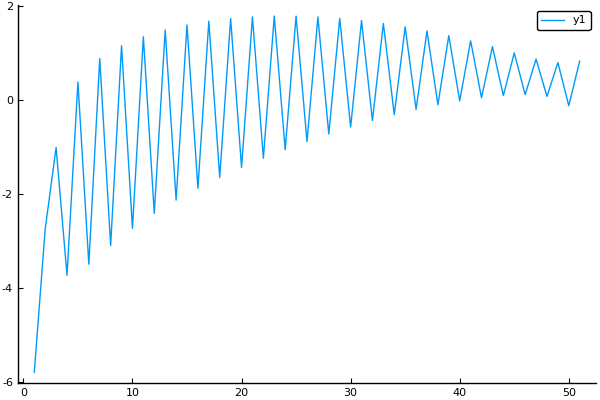

In [121]:
plot(frec.u)

## <span style="color:blue"> Plot </span>

#### Set contour levels and fps

In [123]:
contour_levels = range(0.5*minimum(w.data),stop=0.5*maximum(w.data),length=50)
sample_rate = 5
fps = 25;

In [124]:
contour_levels = range(-0.5,stop=0.5,length=50)

-0.5:0.02040816326530612:0.5

#### Get body verts history

In [125]:
# get verts info based on this regular grid solution
vshist = []
for i = 1:length(bdhist)
    @get bdhist[i] (bs, js, sys)
    push!(vshist, VertsHistory(sys.nbody, bs))
end

#### Plot first and last time field

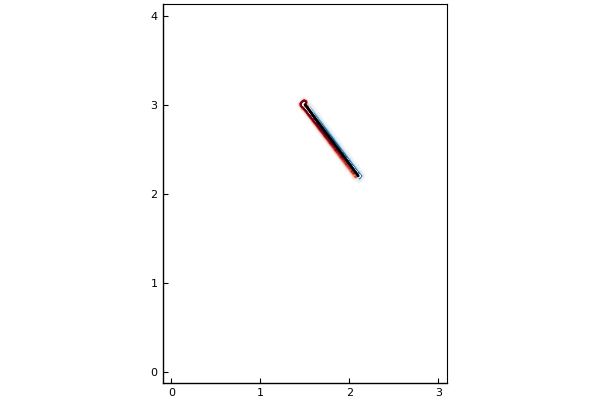

In [126]:
p = plot(xg,yg,whist[1],levels=contour_levels,color=:RdBu_r,clims=(-0.5,0.5))
for i = 1:bd.sys.nbody
    plot!(p,vshist[1][i,2:3,1], vshist[1][i,2:3,2],linewidth=2,linecolor="black")
end
p

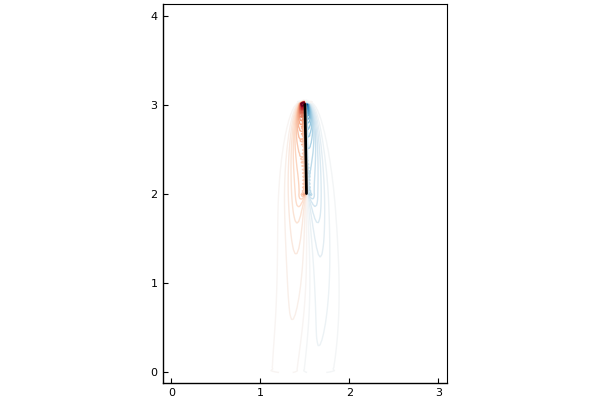

In [128]:
p = plot(xg,yg,whist[end],levels=contour_levels,color=:RdBu_r,clims=(-0.5,0.5))
for i = 1:bd.sys.nbody
    plot!(p,vshist[end][i,2:3,1], vshist[end][i,2:3,2],linewidth=2,linecolor="black")
end
# savefig(p,"plate.eps")
p

#### Body position begining and end

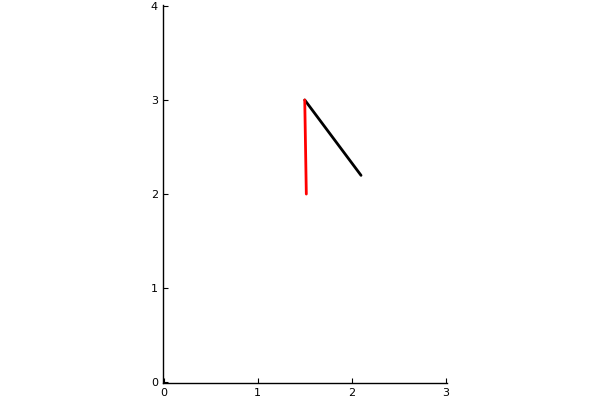

In [130]:
pb = plot()
for i = 1:sys.nbody
    plot!(pb,vshist[1][i,2:3,1], vshist[1][i,2:3,2],linewidth=2,linecolor="black",label="begin")
end
for i = 1:sys.nbody
    plot!(pb,vshist[end][i,2:3,1], vshist[end][i,2:3,2],linewidth=2,linecolor="red",label="end")
end
plot!(pb,xlims=(xg[1],xg[end]), ylims=(yg[1],yg[end]),ratio=1, legend=false)
pb

#### Make gif

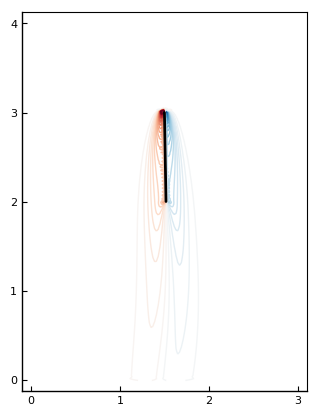

┌ Info: Saved animation to 
│   fn = /mnt/g/Research/FSI.jl/tmp/2dFlag_1body.gif
└ @ Plots /home/fs/.julia/packages/Plots/oiirH/src/animation.jl:90


Plots.AnimatedGif("/mnt/g/Research/FSI.jl/tmp/2dFlag_1body.gif")

In [131]:
anim = @animate for j = 1:sample_rate:length(whist)
# anim = @animate for j = 1:sample_rate:1200
    plot(xg,yg,whist[j],levels=contour_levels,color=:RdBu_r,clims=(-0.5,0.5))
    for i = 1:sys.nbody
        plot!(vshist[j][i,2:3,1], vshist[j][i,2:3,2],linewidth=2,linecolor="black")
    end
end

gif(anim, filename*".gif", fps = fps)

#### Tail trajectory

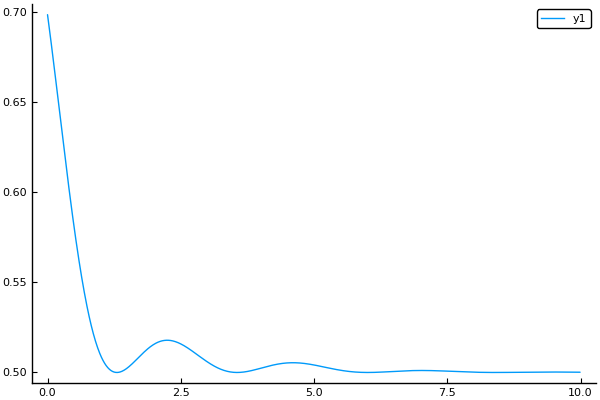

In [133]:
p1hist = []

for i in 1:length(bdhist)
    push!(p1hist,bdhist[i].bs[1].verts_i[3,2]-1.5)    
end

plot(thist,p1hist)

In [134]:
println(p1hist)

Any[0.698742, 0.696501, 0.694242, 0.691965, 0.68967, 0.687359, 0.685031, 0.682687, 0.680329, 0.677957, 0.675571, 0.673174, 0.670767, 0.668349, 0.665921, 0.663486, 0.661043, 0.658594, 0.65614, 0.653682, 0.65122, 0.648756, 0.646291, 0.643825, 0.641359, 0.638895, 0.636434, 0.633976, 0.631522, 0.629074, 0.626632, 0.624197, 0.62177, 0.619351, 0.616942, 0.614545, 0.612158, 0.609784, 0.607423, 0.605076, 0.602744, 0.600427, 0.598126, 0.595843, 0.593577, 0.59133, 0.589102, 0.586894, 0.584707, 0.582541, 0.580396, 0.578274, 0.576175, 0.5741, 0.572049, 0.570023, 0.568022, 0.566047, 0.564098, 0.562176, 0.560281, 0.558413, 0.556573, 0.554762, 0.55298, 0.551226, 0.549502, 0.547807, 0.546142, 0.544508, 0.542903, 0.541329, 0.539786, 0.538274, 0.536793, 0.535343, 0.533924, 0.532537, 0.531181, 0.529857, 0.528564, 0.527302, 0.526072, 0.524874, 0.523707, 0.522571, 0.521466, 0.520392, 0.51935, 0.518338, 0.517356, 0.516406, 0.515485, 0.514595, 0.513735, 0.512905, 0.512104, 0.511332, 0.510589, 0.509875, 0.509

#### Force history

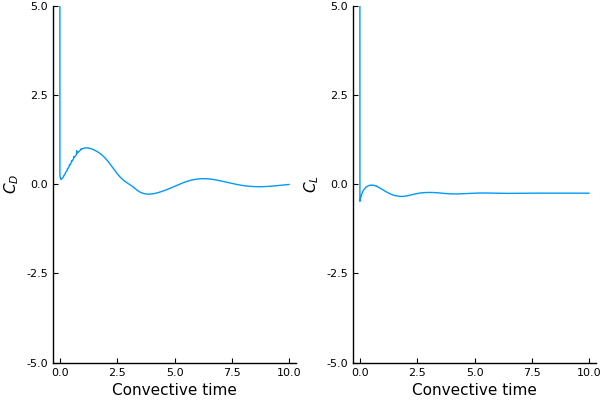

In [135]:
px = plot(thist,2*fx,ylim=(-5,5),xlabel="Convective time",ylabel="\$C_D\$",legend=false)
py = plot(thist,2*fy,ylim=(-5,5),xlabel="Convective time",ylabel="\$C_L\$",legend=false)
plot(px,py)

## <span style="color:blue"> Save Data </span>

#### Save all current data a .bson file

In [136]:
# @save filename*".bson" bd bdhist xg yg whist vshist thist fx fy Δt w qJ v t f

#### Use the following block to extract data

In [137]:
# using Dyn3d
# using ViscousFlow

# @load filename*".bson" bd bdhist xg yg whist vshist thist fx fy Δt w qJ v t f
# @get bd (bs,js,sys);